<a href="https://colab.research.google.com/github/Ultan-Kearns/Artificial-Intelligence-CA/blob/master/Notebooks_Python_DRL_Games_Fall_2021/Technical_project_DRL_Games_Fall_2021/Deep%20Kung-Fu-with-Advantage-Critic/Deep%20Kung-Fu%20with%20advantage%20actor-critic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep Kung-Fu with advantage actor-critic

# Environment Setup

In [1]:
!pip install gym

In [2]:
!apt-get install python-opengl -y

Reading package lists... Done
Building dependency tree       
Reading state information... Done
python-opengl is already the newest version (3.1.0+dfsg-1).
0 upgraded, 0 newly installed, 0 to remove and 37 not upgraded.


In [3]:
!apt install xvfb -y

Reading package lists... Done
Building dependency tree       
Reading state information... Done
xvfb is already the newest version (2:1.19.6-1ubuntu4.10).
0 upgraded, 0 newly installed, 0 to remove and 37 not upgraded.


In [4]:
!pip install pyvirtualdisplay
!pip install piglet

In [5]:
from pyvirtualdisplay import Display
display = Display(visible=0, size=(1400, 900))
display.start()

In [6]:
from __future__ import print_function, division
from IPython.core import display
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

#If you are running on a server, launch xvfb to record game videos
#Please make sure you have xvfb installed
import os
if os.environ.get("DISPLAY") is str and len(os.environ.get("DISPLAY"))!=0:
    !bash ../xvfb start
    %env DISPLAY=:1

# Atari Environment

---



In [7]:
pip install scipy==1.1.0

In [8]:
!apt-get install -y python-numpy python-dev cmake zlib1g-dev libjpeg-dev xvfb libav-tools xorg-dev python-opengl libboost-all-dev libsdl2-dev swig

Reading package lists... Done
Building dependency tree       
Reading state information... Done
Package libav-tools is not available, but is referred to by another package.
This may mean that the package is missing, has been obsoleted, or
is only available from another source
However the following packages replace it:
  ffmpeg

E: Package 'libav-tools' has no installation candidate


In [9]:
!python -m pip install "gym[atari,accept-rom-license]"


In [ ]:
# mount gdrive

from google.colab import drive
drive.mount('/content/gdrive')

# Atari depreacated installing ale-py instead
!python -m pip install ale-py
!pip install gym[atari] 
from ale_py import ALEInterface 
ale = ALEInterface()

!ale-import-roms '/content/gdrive/My Drive/roms'

ale.loadROM('KungFuMaster')


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
[SUPPORTED]           kung_fu_master /content/gdrive/My Drive/roms/KungFuMaster.bin



Imported 1 / 1 ROMs


In [1]:
# Had issue with preprocess atari so needed code from Github
# Reference: https://github.com/sshkhr/Practical_RL/blob/master/week6_policy_based/atari_util.py
# Code by https://github.com/sshkhr 



"""Auxilary files for those who wanted to solve breakout with CEM or policy gradient"""
import numpy as np
import gym
from scipy.misc import imresize
from gym.core import Wrapper
from gym.spaces.box import Box

class PreprocessAtari(Wrapper):
    def __init__(self, env, height=42, width=42, color=False, crop=lambda img: img, 
                 n_frames=4, dim_order='theano', reward_scale=1,):
        """A gym wrapper that reshapes, crops and scales image into the desired shapes"""
        super(PreprocessAtari, self).__init__(env)
        assert dim_order in ('theano', 'tensorflow')
        self.img_size = (height, width)
        self.crop=crop
        self.color=color
        self.dim_order = dim_order
        self.reward_scale = reward_scale
        
        n_channels = (3 * n_frames) if color else n_frames
        obs_shape = [n_channels,height,width] if dim_order == 'theano' else [height,width,n_channels]
        self.observation_space = Box(0.0, 1.0, obs_shape)
        self.framebuffer = np.zeros(obs_shape, 'float32')
        
    def reset(self):
        """resets breakout, returns initial frames"""
        self.framebuffer = np.zeros_like(self.framebuffer)
        self.update_buffer(self.env.reset())
        return self.framebuffer
    
    def step(self,action):
        """plays breakout for 1 step, returns frame buffer"""
        new_img, reward, done, info = self.env.step(action)
        self.update_buffer(new_img)
        return self.framebuffer, reward * self.reward_scale, done, info
    
    ### image processing ###
    
    def update_buffer(self,img):
        img = self.preproc_image(img)
        offset = 3 if self.color else 1
        if self.dim_order == 'theano':
            axis = 0
            cropped_framebuffer = self.framebuffer[:-offset]
        else:
            axis = -1
            cropped_framebuffer = self.framebuffer[:,:,:-offset]
        self.framebuffer = np.concatenate([img, cropped_framebuffer], axis = axis)

    def preproc_image(self, img):
        """what happens to the observation"""
        img = self.crop(img)
        img = imresize(img, self.img_size)
        if not self.color:
            img = img.mean(-1, keepdims=True)
        if self.dim_order == 'theano':
            img = img.transpose([2,0,1]) # [h, w, c] to [c, h, w]
        img = img.astype('float32') / 255.
        return img

# Deep Kung-Fu with advantage actor-critic

---

For starters, let's take a look at the game itself:

 * Image resized to 42x42 and grayscale to run faster
 * Rewards divided by 100 'cuz they are all divisible by 100
 * Agent sees last 4 frames of game to account for object velocity

In [2]:
import gym

def make_env():
    env = gym.make("KungFuMaster-v0")
    env = PreprocessAtari(env, height=42, width=42,
                          crop = lambda img: img[60:-30, 5:],
                          dim_order = 'tensorflow',
                          color=False, n_frames=4,
                          reward_scale = 0.01)
    return env

env = make_env()

obs_shape = env.observation_space.shape
n_actions = env.action_space.n

print("Observation shape:", obs_shape)
print("Num actions:", n_actions)
print("Action names:", env.env.env.get_action_meanings())

Observation shape: (42, 42, 4)
Num actions: 18
Action names: ['NOOP', 'FIRE', 'UP', 'RIGHT', 'LEFT', 'DOWN', 'UPRIGHT', 'UPLEFT', 'DOWNRIGHT', 'DOWNLEFT', 'UPFIRE', 'RIGHTFIRE', 'LEFTFIRE', 'DOWNFIRE', 'UPRIGHTFIRE', 'UPLEFTFIRE', 'DOWNRIGHTFIRE', 'DOWNLEFTFIRE']


/usr/local/lib/python3.7/dist-packages/ale_py/roms/utils.py:90: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for external in metadata.entry_points().get(self.group, []):
/usr/local/lib/python3.7/dist-packages/gym/logger.py:30: UserWarning: WARN: obs_type "image" should be replaced with the image type, one of: rgb, grayscale
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


In [3]:
import matplotlib.pyplot as plt

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:59: DeprecationWarning:     `imresize` is deprecated!
    `imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
    Use ``skimage.transform.resize`` instead.


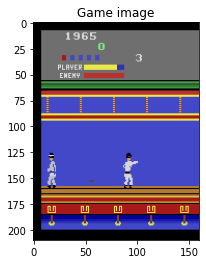

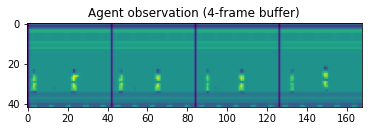

In [4]:
s = env.reset()
for _ in range(100):
    s, _, _, _ = env.step(env.action_space.sample())

plt.title('Game image')
plt.imshow(env.render('rgb_array'))
plt.show()

plt.title('Agent observation (4-frame buffer)')
plt.imshow(s.transpose([0,2,1]).reshape([42,-1]))
plt.show()

# Build an agent

---


We now have to build an agent for actor-critic training - a convolutional neural network that converts states into action probabilities and state values .

Your assignment here is to build and apply a neural network - with any framework you want.

For starters, we want you to implement this architecture: 

After you get above 50 points, we encourage you to experiment with model architecture to score even better.

In [5]:
import tensorflow as tf
tf.compat.v1.reset_default_graph()
sess = tf.compat.v1.InteractiveSession()

In [6]:
from keras.layers import Conv2D, Dense, Flatten, Input
import keras
from keras.models import Model, Sequential

class Agent:
    def __init__(self, name, state_shape, n_actions, reuse=False):
        """A simple actor-critic agent"""
        
        with tf.compat.v1.variable_scope(name, reuse=reuse):
            ####
            inputs = Input(shape=state_shape)
            x = Conv2D(32, (3, 3), strides=2, activation='relu')(inputs)
            x = Conv2D(32, (3, 3), strides=2, activation='relu')(x)
            x = Conv2D(32, (3, 3), strides=2, activation='relu')(x)
            x = Flatten()(x)
            x = Dense(128, activation='relu')(x)
            
            # two different output layers
            logits = Dense(n_actions, activation='linear')(x)
            state_value = Dense(1, activation='linear')(x)
            
            self.network = Model(inputs=inputs, outputs=[logits, state_value])
            
            
            # prepare a graph for agent step
            self.state_t = tf.compat.v1.placeholder('float32', [None,] + list(state_shape))
            self.agent_outputs = self.symbolic_step(self.state_t)
        
    def symbolic_step(self, state_t):
        """Takes agent's previous step and observation, returns next state and whatever it needs to learn (tf tensors)"""
        
        # Apply neural network
        ### Apply agent's neural network to get policy logits and state values.
#         network_output = self.network(state_t)

#         logits = network_output[:,1:]
#         state_value = network_output[:,0]
        
        
        logits, state_value = self.network(state_t)
        state_value = state_value[:, 0]
        
        assert tf.compat.v1.is_numeric_tensor(state_value) and state_value.shape.ndims == 1, \
            "please return 1D tf tensor of state values [you got %s]" % repr(state_value)
        assert tf.compat.v1.is_numeric_tensor(logits) and logits.shape.ndims == 2, \
            "please return 2d tf tensor of logits [you got %s]" % repr(logits)
        # if you triggered state_values assert with your shape being [None, 1], 
        # just select [:, 0]-th element of state values as new state values
        
        return (logits, state_value)
    
    def step(self, state_t):
        """Same as symbolic step except it operates on numpy arrays"""
        sess = tf.compat.v1.get_default_session()
        return sess.run(self.agent_outputs, {self.state_t: state_t})
    
    def sample_actions(self, agent_outputs):
        """pick actions given numeric agent outputs (np arrays)"""
        logits, state_values = agent_outputs
        policy = np.exp(logits) / np.sum(np.exp(logits), axis=-1, keepdims=True)
        return np.array([np.random.choice(len(p), p=p) for p in policy])

In [7]:
tf.compat.v1.disable_eager_execution()
agent = Agent("agent", obs_shape, n_actions)
sess.run(tf.compat.v1.global_variables_initializer())

In [8]:
state = [env.reset()]
logits, value = agent.step(state)
print("action logits:\n", logits)
print("state values:\n", value)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:59: DeprecationWarning:     `imresize` is deprecated!
    `imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
    Use ``skimage.transform.resize`` instead.


action logits:
 [[-0.0505759  -0.03935283  0.02701012 -0.01143071  0.10149945 -0.01792973
   0.00685496 -0.00758218  0.04673084 -0.06996267 -0.08062464  0.02155734
  -0.00827788  0.0267733   0.08556648 -0.02852118 -0.08093078  0.02748336]]
state values:
 [-0.09258553]


# Let's play!

---


Let's build a function that measures agent's average reward.

In [9]:
def evaluate(agent, env, n_games=1):
    """Plays an a game from start till done, returns per-game rewards """

    game_rewards = []
    for _ in range(n_games):
        state = env.reset()
        
        total_reward = 0
        while True:
            action = agent.sample_actions(agent.step([state]))[0]
            state, reward, done, info = env.step(action)
            total_reward += reward
            if done: break
                
        game_rewards.append(total_reward)
    return game_rewards


In [10]:
env_monitor = gym.wrappers.Monitor(env, directory="kungfu_videos", force=True)
rw = evaluate(agent, env_monitor, n_games=3,)
env_monitor.close()
print (rw)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:59: DeprecationWarning:     `imresize` is deprecated!
    `imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
    Use ``skimage.transform.resize`` instead.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:59: DeprecationWarning:     `imresize` is deprecated!
    `imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
    Use ``skimage.transform.resize`` instead.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:59: DeprecationWarning:     `imresize` is deprecated!
    `imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
    Use ``skimage.transform.resize`` instead.


[1.0, 5.0, 0.0]


In [11]:
from IPython.display import HTML
import os

# needed to import code to fix issue with video also changed the dir to remove 
# underscore
# ref for this code below https://stackoverflow.com/questions/57377185/how-play-mp4-video-in-google-colab
video_names = list(filter(lambda s:s.endswith(".mp4"),os.listdir("./kungfu_videos/")))
from base64 import b64encode
mp4 = open("./kungfu_videos/"+video_names[0],'rb').read()
agent_video = "data:video/mp4;base64," + b64encode(mp4).decode()

HTML("""
<video width="640" height="480" controls>
  <source src=%s type="video/mp4">
</video>
""" %agent_video) #this may or may not be _last_ video. Try other indices


# Updating hyper parameters 
Lets see what happens when we add more layers

In [88]:
from keras.layers import Conv2D, Dense, Flatten, Input
import keras
from keras.models import Model, Sequential

class Agent:
    def __init__(self, name, state_shape, n_actions, reuse=False):
        """A simple actor-critic agent"""
        
        with tf.compat.v1.variable_scope(name, reuse=reuse):
            ####
            inputs = Input(shape=state_shape)
            x = Conv2D(256, (3, 3), strides=3, activation='relu')(inputs)
            x = Conv2D(256, (3, 3), strides=2, activation='relu')(x)
            x = Conv2D(256, (3, 3), strides=2, activation='relu')(x)
            x = Flatten()(x)
            x = Dense(256, activation='sigmoid')(x)
            
            # two different output layers
            logits = Dense(n_actions, activation='linear')(x)
            state_value = Dense(1, activation='linear')(x)
            
            self.network = Model(inputs=inputs, outputs=[logits, state_value])
            
            
            # prepare a graph for agent step
            self.state_t = tf.compat.v1.placeholder('float32', [None,] + list(state_shape))
            self.agent_outputs = self.symbolic_step(self.state_t)
        
    def symbolic_step(self, state_t):
        """Takes agent's previous step and observation, returns next state and whatever it needs to learn (tf tensors)"""
        
        # Apply neural network
        ### Apply agent's neural network to get policy logits and state values.
#         network_output = self.network(state_t)

#         logits = network_output[:,1:]
#         state_value = network_output[:,0]
        
        
        logits, state_value = self.network(state_t)
        state_value = state_value[:, 0]
        
        assert tf.compat.v1.is_numeric_tensor(state_value) and state_value.shape.ndims == 1, \
            "please return 1D tf tensor of state values [you got %s]" % repr(state_value)
        assert tf.compat.v1.is_numeric_tensor(logits) and logits.shape.ndims == 2, \
            "please return 2d tf tensor of logits [you got %s]" % repr(logits)
        # if you triggered state_values assert with your shape being [None, 1], 
        # just select [:, 0]-th element of state values as new state values
        
        return (logits, state_value)
    
    def step(self, state_t):
        """Same as symbolic step except it operates on numpy arrays"""
        sess = tf.compat.v1.get_default_session()
        return sess.run(self.agent_outputs, {self.state_t: state_t})
    
    def sample_actions(self, agent_outputs):
        """pick actions given numeric agent outputs (np arrays)"""
        logits, state_values = agent_outputs
        policy = np.exp(logits) / np.sum(np.exp(logits), axis=-1, keepdims=True)
        return np.array([np.random.choice(len(p), p=p) for p in policy])

In [89]:
tf.compat.v1.disable_eager_execution()
agent = Agent("agent", obs_shape, n_actions)
sess.run(tf.compat.v1.global_variables_initializer())

In [90]:
state = [env.reset()]
logits, value = agent.step(state)
print("action logits:\n", logits)
print("state values:\n", value)

action logits:
 [[ 0.55473465  0.4708888  -0.21011409  0.41094598  0.02717499 -0.30365884
   1.4081815   0.03926349  0.04519415 -0.06430647 -0.11389134  0.55398315
   0.35914576 -0.15288854 -0.5346352   1.5135336  -0.47247642  0.34366298]]
state values:
 [0.839368]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:59: DeprecationWarning:     `imresize` is deprecated!
    `imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
    Use ``skimage.transform.resize`` instead.


In [91]:
def evaluate(agent, env, n_games=1):
    """Plays an a game from start till done, returns per-game rewards """

    game_rewards = []
    for _ in range(n_games):
        state = env.reset()
        
        total_reward = 0
        while True:
            action = agent.sample_actions(agent.step([state]))[0]
            state, reward, done, info = env.step(action)
            total_reward += reward
            if done: break
                
        game_rewards.append(total_reward)
    return game_rewards


In [92]:
env_monitor = gym.wrappers.Monitor(env, directory="kungfu_videos", force=True)
rw = evaluate(agent, env_monitor, n_games=3,)
env_monitor.close()
print (rw)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:59: DeprecationWarning:     `imresize` is deprecated!
    `imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
    Use ``skimage.transform.resize`` instead.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:59: DeprecationWarning:     `imresize` is deprecated!
    `imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
    Use ``skimage.transform.resize`` instead.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:59: DeprecationWarning:     `imresize` is deprecated!
    `imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
    Use ``skimage.transform.resize`` instead.


[9.0, 9.0, 5.0]


In [93]:
from IPython.display import HTML
import os

# needed to import code to fix issue with video also changed the dir to remove 
# underscore
# ref for this code below https://stackoverflow.com/questions/57377185/how-play-mp4-video-in-google-colab
video_names = list(filter(lambda s:s.endswith(".mp4"),os.listdir("./kungfu_videos/")))
from base64 import b64encode
mp4 = open("./kungfu_videos/"+video_names[0],'rb').read()
agent_video = "data:video/mp4;base64," + b64encode(mp4).decode()

HTML("""
<video width="640" height="480" controls>
  <source src=%s type="video/mp4">
</video>
""" %agent_video) #this may or may not be _last_ video. Try other indices


# Training on parallel games

---



![alt text](https://camo.githubusercontent.com/f894eba2ee745652f1fc95484cfa45bf26decb8e/68747470733a2f2f6769746875622e636f6d2f79616e646578646174617363686f6f6c2f50726163746963616c5f524c2f7261772f6d61737465722f7965745f616e6f746865725f7765656b2f5f7265736f757263652f2f656e765f706f6f6c2e706e67)

To make actor-critic training more stable, we shall play several games in parallel. This means ya'll have to initialize several parallel gym envs, send agent's actions there and .reset() each env if it becomes terminated. To minimize learner brain damage, we've taken care of them for ya - just make sure you read it before you use it.

In [ ]:
class EnvBatch:
    def __init__(self, n_envs = 10):
        """ Creates n_envs environments and babysits them for ya' """
        self.envs = [make_env() for _ in range(n_envs)]
        
    def reset(self):
        """ Reset all games and return [n_envs, *obs_shape] observations """
        return np.array([env.reset() for env in self.envs])
    
    def step(self, actions):
        """
        Send a vector[batch_size] of actions into respective environments
        :returns: observations[n_envs, *obs_shape], rewards[n_envs], done[n_envs,], info[n_envs]
        """
        results = [env.step(a) for env, a in zip(self.envs, actions)]
        new_obs, rewards, done, infos = map(np.array, zip(*results))
        
        # reset environments automatically
        for i in range(len(self.envs)):
            if done[i]:
                new_obs[i] = self.envs[i].reset()
        
        return new_obs, rewards, done, infos

In [ ]:
env_batch = EnvBatch(10)

batch_states = env_batch.reset()

batch_actions = agent.sample_actions(agent.step(batch_states))

batch_next_states, batch_rewards, batch_done, _ = env_batch.step(batch_actions)

print("State shape:", batch_states.shape)
print("Actions:", batch_actions[:3])
print("Rewards:", batch_rewards[:3])
print("Done:", batch_done[:3])


# Actor-critic

---


Here we define a loss functions and learning algorithms as usual.

In [ ]:
# These placeholders mean exactly the same as in "Let's try it out" section above
tf.compat.v1.disable_eager_execution()
states_ph = tf.compat.v1.placeholder('float32', [None,] + list(obs_shape))    
next_states_ph =  tf.compat.v1.placeholder('float32', [None,] + list(obs_shape))
actions_ph =  tf.compat.v1.placeholder('int32', (None,))
rewards_ph =  tf.compat.v1.placeholder('float32', (None,))
is_done_ph =  tf.compat.v1.placeholder('float32', (None,))

In [ ]:
# logits[n_envs, n_actions] and state_values[n_envs, n_actions]
logits, state_values = agent.symbolic_step(states_ph)
next_logits, next_state_values = agent.symbolic_step(next_states_ph)
next_state_values = next_state_values * (1 - is_done_ph)

# probabilities and log-probabilities for all actions
probs = tf.nn.softmax(logits)            # [n_envs, n_actions]
logprobs = tf.nn.log_softmax(logits)     # [n_envs, n_actions]

# log-probabilities only for agent's chosen actions
logp_actions = tf.reduce_sum(logprobs * tf.one_hot(actions_ph, n_actions), axis=-1) # [n_envs,]

In [ ]:


# compute advantage using rewards_ph, state_values and next_state_values
gamma = 0.99
advantage = rewards_ph + gamma*next_state_values - state_values

assert advantage.shape.ndims == 1, "please compute advantage for each sample, vector of shape [n_envs,]"

# compute policy entropy given logits_seq. Mind the "-" sign!
entropy =  -tf.reduce_sum(probs * logprobs, 1, name="entropy")

assert entropy.shape.ndims == 1, "please compute pointwise entropy vector of shape [n_envs,] "



actor_loss =  - tf.reduce_mean(logp_actions * tf.stop_gradient(advantage)) - 0.001 * tf.reduce_mean(entropy)

# compute target state values using temporal difference formula. Use rewards_ph and next_step_values
target_state_values = rewards_ph+gamma*next_state_values

critic_loss = tf.reduce_mean((state_values - tf.stop_gradient(target_state_values))**2 )

train_step = tf.compat.v1.train.AdamOptimizer(1e-4).minimize(actor_loss + critic_loss)
sess.run(tf.compat.v1.global_variables_initializer())

In [ ]:
# Sanity checks to catch some errors. Specific to KungFuMaster in assignment's default setup.
l_act, l_crit, adv, ent = sess.run([actor_loss, critic_loss, advantage, entropy], feed_dict = {
        states_ph: batch_states,
        actions_ph: batch_actions,
        next_states_ph: batch_states,
        rewards_ph: batch_rewards,
        is_done_ph: batch_done,
    })

assert abs(l_act) < 100 and abs(l_crit) < 100, "losses seem abnormally large"
assert 0 <= ent.mean() <= np.log(n_actions), "impossible entropy value, double-check the formula pls"
if ent.mean() < np.log(n_actions) / 2: print("Entropy is too low for untrained agent")
print("You just might be fine!")

In [ ]:
!pip install tqdm

# Train

---


Just the usual - play a bit, compute loss, follow the graidents, repeat a few million times.

![alt text](https://camo.githubusercontent.com/69cc1e7cffa2ebd5db67c39f7c7c2724aaf5594b/687474703a2f2f696d61676573362e66616e706f702e636f6d2f696d6167652f70686f746f732f33383930303030302f44616e69656c2d73616e2d747261696e696e672d7468652d6b61726174652d6b69642d33383934373336312d3439392d3238382e676966)



In [ ]:
!pip install pandas

In [ ]:
from IPython.display import clear_output
from tqdm import trange
import pandas as pd
#from pandas import ewm

env_batch = EnvBatch(10)
batch_states = env_batch.reset()

rewards_history = []
entropy_history = []
df = pd.DataFrame(data=batch_rewards)

In [ ]:
df.ewm(halflife=12).mean()

In [ ]:
for i in trange(100000): 
    
    batch_actions = agent.sample_actions(agent.step(batch_states))
    batch_next_states, batch_rewards, batch_done, _ = env_batch.step(batch_actions)
    
    feed_dict = {
        states_ph: batch_states,
        actions_ph: batch_actions,
        next_states_ph: batch_next_states,
        rewards_ph: batch_rewards,
        is_done_ph: batch_done,
    }
    batch_states = batch_next_states
    
    _, ent_t = sess.run([train_step, entropy], feed_dict)
    entropy_history.append(np.mean(ent_t))

    if i % 500 == 0: 
        if i % 2500 == 0:
            rewards_history.append(np.mean(evaluate(agent, env, n_games=3)))
            if rewards_history[-1] >= 50:
                print("Your agent has earned the yellow belt")

        clear_output(True)
        plt.figure(figsize=[8,4])
        plt.subplot(1,2,1)
        plt.plot(rewards_history, label='rewards')
        df = pd.DataFrame(rewards_history)
        plt.plot(df.ewm(halflife=1000).mean(), marker='.', label='rewards ewma@10')
        plt.title("Session rewards"); plt.grid(); plt.legend()
        
        plt.subplot(1,2,2)
        plt.plot(entropy_history, label='entropy')
        df2 = pd.DataFrame(entropy_history)
        plt.plot(df2.ewm(halflife=1000).mean(), label='entropy ewma@1000')
        plt.title("Policy entropy"); plt.grid(); plt.legend()        
        plt.show()
        
        



In [ ]:
env_monitor = gym.wrappers.Monitor(env, directory="kungfu_videos", force=True)
final_rewards = evaluate(agent, env_monitor, n_games=1,)
env_monitor.close()
print("Final mean reward:", np.mean(final_rewards))

video_names = list(filter(lambda s:s.endswith(".mp4"),os.listdir("./kungfu_videos/")))